In [ ]:
!pip install torchmetrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/CCPD2019-dl1.zip

In [4]:
import numpy as np
import pandas as pd
import random
import os
import torch
import torchvision
import sklearn
import cv2
import albumentations as A
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchmetrics import CharErrorRate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

## Utils

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def remove_duplicates(lst):
    if len(lst) < 2:
        return lst
    
    res = ''
    for c in lst:
        if res == '':
            res = c
        else:
            if c == res[-1]:
                continue
            else:
                res += c
    return res


def decode(predictions, encoder):
    predictions = predictions.permute(1, 0, 2)
    predictions = torch.softmax(predictions, 2)
    predictions = torch.argmax(predictions, 2)
    predictions = predictions.detach().cpu().numpy()
    decoded = []
    for i in range(predictions.shape[0]):
        buffer = []
        for char in predictions[i, :]:
            char -= 1
            if char == -1:
                buffer.append('-')
            else:
                c = encoder.inverse_transform([char])[0]
                buffer.append(c)
        buffer = remove_duplicates(buffer)
        res = ''.join(buffer).replace('-', '')
        decoded.append(res)
    return decoded

## Fix seed

In [6]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(2023)

## Prepare data

Решил перевести в черно-белый формат, так визуально номера видны намного лучше.

In [7]:
class CCPD(Dataset):
    def __init__(self, images, data_path, targets, transforms=None):
        self.images = images
        self.targets = targets
        self.data_path = data_path
        self.transforms = transforms

    def __getitem__(self, idx):
        img_name = self.images[idx]
        target = self.targets[idx]

        image_path = os.path.join(self.data_path, img_name)
        img = cv2.imread(image_path) # BGR

        if self.transforms is not None:
            img = self.transforms(image=img)['image']

        img = self.preprocess(img)

        return torch.from_numpy(img).float(), target

    def __len__(self):
        return len(self.images)

    def preprocess(self, img):
        img = cv2.resize(img, (255, 75))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = (img - 127.5) / 128
        img = np.expand_dims(img, axis=0)

        return img

In [8]:
train_images = os.listdir('/content/CCPD2019-dl1/train')

train_targets_original = [image.split('-')[1].split('.')[0] for image in train_images]
train_targets = [[c for c in target] for target in train_targets_original]
train_targets_flattened = [c for target in train_targets for c in target]

encoder = LabelEncoder()
encoder.fit(train_targets_flattened)
targets_encoded = np.array([encoder.transform(target) for target in train_targets]) + 1

In [9]:
train_images, val_images, train_targets, val_targets, train_targets_original, val_targets_original = train_test_split(train_images,
                                                                                                                      targets_encoded,
                                                                                                                      train_targets_original,
                                                                                                                      test_size=0.2,
                                                                                                                      shuffle=True,
                                                                                                                      random_state=2023)

In [10]:
train_dataset = CCPD(train_images, '/content/CCPD2019-dl1/train', train_targets)
train_dataloader = DataLoader(train_dataset, batch_size=400, shuffle=True)

val_dataset = CCPD(val_images, '/content/CCPD2019-dl1/train', val_targets)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

## Model

3 сверточных слоя, далее bidiLSTM.

In [11]:
class CRNN(nn.Module):
    def __init__(self, alphabet_power):
        super().__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=(3, 6), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 6), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 6), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear = nn.Linear(576, 64)
        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(64, 32, bidirectional=True, num_layers=2, dropout=0.2, batch_first=True)
        self.output = nn.Linear(64, alphabet_power + 1)

    def forward(self, images):
        batch_size = images.size(0)

        x = self.conv_layer1(images)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(batch_size, x.size(1), -1)
        x = F.relu(self.linear(x))
        x = self.dropout(x)
        x, _ = self.lstm(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        return x

## Training

Обучаем модель в mixed-precision режиме для скорости, используем CTC-loss.

In [12]:
def to_python_float(t):
    if hasattr(t, 'item'):
        return t.item()
    else:
        return t[0]


def train_recognizer(train_loader, model, optimizer, epoch, print_freq=150,
                     amp_autocast=None, scaler=None):
    losses = AverageMeter()

    model.train()

    i = 0

    for i, (input, target) in enumerate(train_loader):
        i += 1
        input = input.cuda()
        target = target.cuda()

        with amp_autocast():
            output = model(input)
            bs = input.size(0)
            log_probs = F.log_softmax(output, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(bs,), fill_value=target.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, target, input_lengths, target_lengths
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        reduced_loss = loss.data

        losses.update(to_python_float(reduced_loss), input.size(0))

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.avg:.7f}\t'.format(epoch, i, len(train_loader),
                                             loss=losses))

    print('Epoch: [{0}][{1}/{2}]\t'
          'Loss {loss.avg:.4f}\t'.format(epoch, i, len(train_loader),
                                     loss=losses))

    return losses.avg

    

def validate_recognizer(val_loader, model):
    losses = AverageMeter()

    model.eval()

    preds = []
    i = 0
    for i, (input, target) in enumerate(val_loader):
        i += 1
        input = input.cuda()
        target = target.cuda()

        with torch.no_grad():
            output = model(input)
            bs = input.size(0)
            log_probs = F.log_softmax(output, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(bs,), fill_value=target.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, target, input_lengths, target_lengths
            )

        preds.append(output)

        reduced_loss = loss.data

        losses.update(to_python_float(reduced_loss), input.size(0))
    
    decoded_output = []
    for prediction in preds:
        decoded = decode(prediction, encoder)
        decoded_output.extend(decoded)
    
    prec1 = sklearn.metrics.accuracy_score(val_targets_original, decoded_output)
    metric = CharErrorRate()
    cer_metric = metric(decoded_output, val_targets_original)

    print('')
    print(' *Loss {loss.avg:.4f} VAL_Prec@1 {prec1:.3f} VAL_CER {cer:.3f}'
          .format(loss=losses, prec1=prec1, cer=cer_metric))
    print('')

    return losses.avg, prec1, cer_metric

In [13]:
model = CRNN(alphabet_power=len(encoder.classes_))
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10

scaler = torch.cuda.amp.GradScaler()
amp_autocast = torch.cuda.amp.autocast

for epoch in range(EPOCHS):
    start_time = datetime.now()

    train_loss = train_recognizer(train_dataloader, model, optimizer, epoch,
                                  scaler=scaler, amp_autocast=amp_autocast)

    elapsed_time_secs = (datetime.now() - start_time).seconds

    print("Epoch took: {}".format(timedelta(seconds=elapsed_time_secs)))

    valid_loss = validate_recognizer(val_dataloader, model)

    # lr_scheduler.step(prec1)

    # if best_acc < prec1:
    #     torch.save(model.state_dict(), 'best.pth')
    #     best_acc = prec1

Epoch: [0][150/400]	Loss 4.7114613	
Epoch: [0][300/400]	Loss 3.7990638	
Epoch: [0][400/400]	Loss 3.5145	
Epoch took: 0:07:52

 *Loss 2.5986 VAL_Prec@1 0.000 VAL_CER 0.732

Epoch: [1][150/400]	Loss 2.5184106	
Epoch: [1][300/400]	Loss 2.3398625	
Epoch: [1][400/400]	Loss 2.1376	
Epoch took: 0:06:24

 *Loss 1.1690 VAL_Prec@1 0.000 VAL_CER 0.557

Epoch: [2][150/400]	Loss 0.8174179	
Epoch: [2][300/400]	Loss 0.5612612	
Epoch: [2][400/400]	Loss 0.4597	
Epoch took: 0:06:15

 *Loss 0.0959 VAL_Prec@1 0.901 VAL_CER 0.015

Epoch: [3][150/400]	Loss 0.1021776	
Epoch: [3][300/400]	Loss 0.0853603	
Epoch: [3][400/400]	Loss 0.0770	
Epoch took: 0:06:14

 *Loss 0.0334 VAL_Prec@1 0.975 VAL_CER 0.004

Epoch: [4][150/400]	Loss 0.0414650	
Epoch: [4][300/400]	Loss 0.0381728	
Epoch: [4][400/400]	Loss 0.0363	
Epoch took: 0:06:13

 *Loss 0.0208 VAL_Prec@1 0.977 VAL_CER 0.003

Epoch: [5][150/400]	Loss 0.0268285	
Epoch: [5][300/400]	Loss 0.0252280	
Epoch: [5][400/400]	Loss 0.0246	
Epoch took: 0:06:13

 *Loss 0.0159 

In [19]:
torch.save(model.state_dict(), 'crnn-10epochs.pth')

Имеем хорошие значения метрик на валидации даже без аугментаций. Наверное, потому что датасет достаточно большой и с качественными фотографиями.

## Test predictions

In [14]:
test_images = os.listdir('/content/CCPD2019-dl1/test')

test_targets_original = [image.split('-')[1].split('.')[0] for image in test_images]
test_targets = [[c for c in target] for target in test_targets_original]
test_targets_encoded = np.array([encoder.transform(target) for target in test_targets]) + 1

In [15]:
test_dataset = CCPD(test_images, '/content/CCPD2019-dl1/test', test_targets_encoded)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
model.eval()

preds = []
i = 0
for i, (input, target) in enumerate(test_dataloader):
    i += 1
    input = input.cuda()
    target = target.cuda()

    with torch.no_grad():
        output = model(input)
    
    preds.append(output)

decoded_output = []
for prediction in preds:
    decoded = decode(prediction, encoder)
    decoded_output.extend(decoded)

In [18]:
prec1 = sklearn.metrics.accuracy_score(test_targets_original, decoded_output)
print(f'Test accuracy: {prec1:.4f}')
metric = CharErrorRate()
cer_metric = metric(decoded_output, test_targets_original)
print(f'Test CER: {cer_metric:.4f}')

Test accuracy: 0.9664
Test CER: 0.0060


 И на тесте получаем отличные результаты, `CER` очень близок к нулю.

## Model mistakes analysis

In [35]:
cer = CharErrorRate()
CERs = []
for decoded, target in zip(decoded_output, test_targets_original):
    CERs.append(cer(decoded, target).item())

In [38]:
CERs = np.array(CERs)

In [81]:
print(f'Количество ошибок: {(CERs != 0).sum()}/{CERs.size}')

Количество ошибок: 336/9999


Посмотрим на наиболее плохие

In [50]:
bad_score_image_idxs = np.argwhere(CERs >= 0.5).squeeze(1)
bad_score_image_idxs

array([ 923, 2375, 2931, 3295, 6426, 6589, 8104])

In [51]:
for idx in bad_score_image_idxs:
    print(decoded_output[idx], test_targets_original[idx])

皖AT9999 皖AF888S
皖87A63 皖A83453
浙32999 皖AK927W
皖TS39 皖AMQ059
皖A25352 皖A2W003
皖AS9 皖AD0T89
浙AR1Q70 皖AB1930


Посмотрим на соответствующие картинки

In [69]:
bad_images_paths = [os.path.join('/content/CCPD2019-dl1/test', test_images[idx]) for idx in bad_score_image_idxs]

In [70]:
bad_images = []

for path in bad_images_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, (255, 75))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = (img - 127.5) / 128
    bad_images.append(img)

Посмотрим на эти плохие картинки

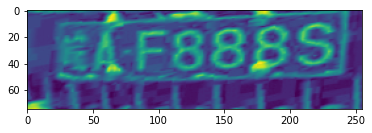

In [71]:
plt.imshow(bad_images[0])

In [72]:
print(decoded_output[bad_score_image_idxs[0]], test_targets_original[bad_score_image_idxs[0]])

皖AT9999 皖AF888S


Первый знак очень смазан, но несмотря на это был правильно распознан, но начиная с третьего что-то пошло не так: F распозналась как T, а 8 и S как 9. Впрочем весьма похожие по формам символы.

Посмотрим на следующую.

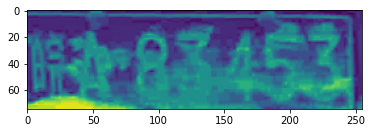

In [73]:
plt.imshow(bad_images[1])

In [77]:
print(decoded_output[bad_score_image_idxs[1]], test_targets_original[bad_score_image_idxs[1]])

皖87A63 皖A83453


Какая-то плохая по качеству фотография, первая А совсем не распозналась, а нижние половины символов почти не различимы, поэтому модель видимо опиралась лишь на верхнюю часть символов, что особо видно из предсказанной А вместо истинной 4, и 7 вместо 3 с резким углом.

Посмотрим на следующую

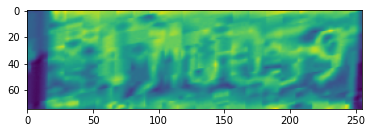

In [80]:
plt.imshow(bad_images[3])

In [79]:
print(decoded_output[bad_score_image_idxs[3]], test_targets_original[bad_score_image_idxs[3]])

皖TS39 皖AMQ059


Ужас, тут вообще еле разглядываются символы, но те, которые видны четко, модель распознала

Следующая

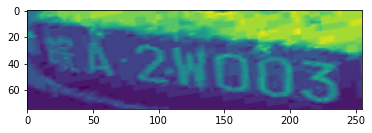

In [82]:
plt.imshow(bad_images[4])

In [83]:
print(decoded_output[bad_score_image_idxs[4]], test_targets_original[bad_score_image_idxs[4]])

皖A25352 皖A2W003


Здесь визуально все символы различимы, но модель почему-то не справилась с некоторыми: нули она приняла за 3 и 5, что похожи на 0 отдельными частями.

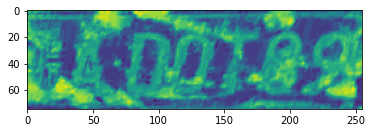

In [87]:
plt.imshow(bad_images[5])

In [88]:
print(decoded_output[bad_score_image_idxs[5]], test_targets_original[bad_score_image_idxs[5]])

皖AS9 皖AD0T89


Опять ужасного качества картинка в чернобелом формате, распозналось что действительно видно.

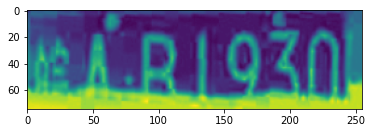

In [89]:
plt.imshow(bad_images[6])

In [90]:
print(decoded_output[bad_score_image_idxs[6]], test_targets_original[bad_score_image_idxs[6]])

浙AR1Q70 皖AB1930


Первый символ едва различим на фотографии, вот и модель не справилась с этим. Нижние части символов опять не видно, из-за чего вместо B получилась R. Вместо тройки опять получилась семерка.

В целом судя по этим фотографиям лишь на одной все символы хорошо различимы человеческим глазом, а на остальных почти невозможно разобрать что написано, и ошибки модели в конкретных случаях можно проинтерпретировать, они имеют за собой какой-то смысл (например, не видно нижнюю половину тройки и модель думает, что это семерка). Поэтому эти ошибки можно скинуть на некачественные фотографии.